In [211]:
import glob
import os
import re
import json
import itertools
import pandas as pd
import polars as pl
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Check DATA

The metadata_participants.txt contains demographics and derived metrics for each participant.
The column names are described as follows:
<table>
    <tr><td>PARTICIPANT_ID</td><td>Unique ID of participant</td></tr>
    <tr><td>AGE</td><td>Participant's age</td></tr>
    <tr><td>GENDER</td><td>Participant's gender</td></tr>
    <tr><td>HAS_TAKEN_TYPING_COURSE</td><td>Whether the participant has taken a typing course (1) or not (0)</td></tr>
    <tr><td>COUNTRY</td><td>Country from which the participant has taken the study</td></tr>
    <tr><td>KEYBOARD_LAYOUT</td><td>QWERTY, AZERTY, QWERTZ or other layout</td></tr>
    <tr><td>NATIVE_LANGUAGE</td><td>Native language of participant</td></tr>
    <tr><td>FINGERS</td><td>choice between 1-2, 3-4, 5-6, 7-8 and 9-10 fingers used</td></tr>
    <tr><td>TIME_SPENT_TYPING</td><td>Number of hours spent typing per day</td></tr>
    <tr><td>KEYBOARD_TYPE</td><td>full (desktop), laptop, small (physical) or (on-screen) touch keyboard</td></tr>
    <tr><td>ERROR_RATE(%)</td><td>Average error rate</td></tr>
    <tr><td>AVG_WPM</td><td>Average words per minute</td></tr>
    <tr><td>AVG_IKI</td><td>Average inter-key interval</td></tr>
    <tr><td>ROLLOVER</td><td>Average rollover ratio</td></tr>
    <tr><td>KSPC</td><td>Average Keystrokes per Character</td></tr>
    <tr><td>AVG_KEYPRESS</td><td>Average keypress duration</td></tr>
</table>

Files named number_keystrokes.txt are the keystroke-by-keystroke logs for all test sentences transcribed by the participant ID = number.<br>
The column names are described as follows: <br>
    
 <table>
    <tr><td>PARTICIPANT_ID</td><td>Unique ID of participant</td></tr>
    <tr><td>TEST_SECTION_ID</td><td>Unique ID of sentence within a participant's test</td></tr>
    <tr><td>SENTENCE</td><td>Presented sentence</td></tr>
    <tr><td>USER_INPUT</td><td>Transcribed sentence</td></tr>
    <tr><td>KEYSTROKE_ID</td><td>Unique keystroke id (across all participants)</td></tr>
    <tr><td>PRESS_TIME</td><td>Timestamp when the key was pressed</td></tr>
    <tr><td>RELEASE_TIME</td><td>Timestamp when the key was released</td></tr>
    <tr><td>LETTER</td><td>String representation of the pressed key</td></tr>
    <tr><td>KEYCODE</td><td>JavaScript keycode of the pressed key</td></tr>
</table>

For some users, the typed letter was not logged correctly. Instead, the corresponding javascript keycode can be used. <br>


**Initial thoughts**: <br>
- calculate flight time between neighbouring symbols<br>
- find correct letter types (using keycodes)<br>
- remove small (physical) or (on-screen) touch keyboard<br>

In [212]:
class Mapper:
    
    def __init__(self):
        self.KEY_TO_CODE = dict()
        with open("keylogger/key-codes.json", "rb") as f:
            self.KEY_TO_CODE = json.load(f)
        self.KEY_TO_CODE["<SoS>"] = 0 # Start of Sequence
        self.KEY_TO_CODE = dict(sorted(self.KEY_TO_CODE.items(), key=lambda x: x[1]))
        self.KEY_CODES = list(self.KEY_TO_CODE.values())
        self.dict_size = len(self.KEY_TO_CODE)
        self.KEY_TO_CODE["UNKNOWN"] = -1
        self.CODE_TO_KEY = { v: k for k, v in self.KEY_TO_CODE.items() }
        self.inner_mapping = { k: i for i, k in enumerate(self.KEY_CODES) }
        self.reversed_inner_mapping = {i: k for i, k in enumerate(self.KEY_CODES)}
        
    def get_key_from_code(self, code: int):
        try:
            return self.CODE_TO_KEY[code]
        except:
            return "Code not found"
    
    def get_code_from_key(self, key: str):
        try:
            return self.KEY_TO_CODE[key]
        except:
            return "Key not found"
        
    def get_key_from_mapped_code(self, code: int):
        try:
            code = self.reversed_inner_mapping[code]
            return self.get_key_from_code(code)
        except:
            return "Mapped code not found"
    
    def get_mapped_code_from_key(self, key: str):
        try:
            code = self.get_code_from_key(key)
            return self.inner_mapping[code]
        except:
            return "Key not found"
    
    def get_mapped_code_from_code(self, code: int):
        try:
            return self.inner_mapping[code]
        except:
            return "Code not found"
        
    def get_code_from_mapped_code(self, code: int):
        try:
            return self.reversed_inner_mapping[code]
        except:
            return "Mapped code not found"
            

In [213]:
COUNTRY_MAP = {
    "US": "United States",
    "GB": "Great Britain",
    "MY": "Malaysia",
    "KR": "Korea",
    "CA": "Canada",
    "PH": "Philippines"
}

LANGUAGE_MAP = {
    "en": "English",
    "zh": "Chinese",
    "tl": "Tagalog", # Philippines
    "cy": "Welsh"
}

MAIN_DIR = "data/small_data"

participant_ids = [re.findall(r"[0-9]+", f)[0] for f in os.listdir(MAIN_DIR) if re.match("[0-9]+", f)]

### Features to calculate 
Link: https://towardsdatascience.com/keystroke-dynamics-analysis-and-prediction-part-1-eda-3fe2d25bac04 <br>
- **Hold Time (aka Dwell Time)**: Time the key is pressed
- **Press-Press Time**: Time between the presses of 2 consecutive keys
- **Release-Press Time (aka Flight Time)**: Time to 'fly' from one key to another (negative in case of rollover)
- **Release-Release Time**: Time between the releases of 2 consecutive keys  

**ROLLOVER** - RELEASE_PRESS_TIME IS NEGATIVE!!!

In [214]:
def read_data_for_participant(participant_id: int, 
                              calculate_features: bool=True,
                              drop_timestamps: bool=True,
                              print_info: bool=True):
    global MAIN_DIR
    df = pl.read_csv(os.path.join(MAIN_DIR, f"{participant_id}_keystrokes.txt"), sep="\t")
    df = df.with_columns([pl.col("LETTER").str.to_lowercase().alias("LETTER")])
    if calculate_features:
        new_sentences = df["TEST_SECTION_ID"] == df.shift_and_fill(1, 0)["TEST_SECTION_ID"]
        df = df.select([
            (pl.col("RELEASE_TIME") - pl.col("PRESS_TIME")).alias("HOLD_TIME"),
            pl.when(new_sentences).then(
                pl.col("KEYCODE").shift_and_fill(1, 0)
            ).otherwise(0).alias("PREV_KEYCODE"),
            pl.when(new_sentences).then(
                pl.col("PRESS_TIME") - pl.col("PRESS_TIME").shift_and_fill(1, 0)
            ).otherwise(0).alias("PRESS_PRESS_TIME"),
            pl.when(new_sentences).then(
                pl.col("PRESS_TIME") - pl.col("RELEASE_TIME").shift_and_fill(1, 0)
            ).otherwise(0).alias("RELEASE_PRESS_TIME"),
            pl.when(new_sentences).then(
                pl.col("RELEASE_TIME") - pl.col("RELEASE_TIME").shift_and_fill(1, 0)
            ).otherwise(0).alias("RELEASE_RELEASE_TIME"),            
            pl.col("*")
        ])
    if drop_timestamps: df.drop(["RELEASE_TIME", "PRESS_TIME"])
    if print_info:
        print(f"{df.filter(pl.col('SENTENCE') == pl.col('USER_INPUT'))['TEST_SECTION_ID'].n_unique()}",
              f"/ {df['TEST_SECTION_ID'].n_unique()} sentences were written correctly",
              f"by the participant {participant_id}")
        
    return df

In [215]:
df = read_data_for_participant(145007)
df.head(5)

10 / 15 sentences were written correctly by the participant 145007


HOLD_TIME,PREV_KEYCODE,PRESS_PRESS_TIME,RELEASE_PRESS_TIME,RELEASE_RELEASE_TIME,PARTICIPANT_ID,TEST_SECTION_ID,SENTENCE,USER_INPUT,KEYSTROKE_ID,PRESS_TIME,RELEASE_TIME,LETTER,KEYCODE
i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,i64,str,i64
247,0,0,0,0,145007,1577476,"""I will be out ...","""I will be out ...",74993989,1473871859057,1473871859304,"""shift""",16
96,16,144,-103,-7,145007,1577476,"""I will be out ...","""I will be out ...",74993987,1473871859201,1473871859297,"""i""",73
96,73,111,15,111,145007,1577476,"""I will be out ...","""I will be out ...",74993991,1473871859312,1473871859408,""" """,32
96,32,112,16,112,145007,1577476,"""I will be out ...","""I will be out ...",74993993,1473871859424,1473871859520,"""w""",87
64,87,80,-16,48,145007,1577476,"""I will be out ...","""I will be out ...",74993995,1473871859504,1473871859568,"""i""",73


In [216]:
metadata = pl.read_csv(os.path.join(MAIN_DIR, "metadata_participants.txt"), sep="\t")
metadata = metadata.with_columns([
    pl.col("COUNTRY").map_dict(COUNTRY_MAP),
    pl.col("NATIVE_LANGUAGE").map_dict(LANGUAGE_MAP)
])

In [217]:
for participant in participant_ids:
    df = read_data_for_participant(participant, print_info=False)
    calculated = df.filter(pl.col("RELEASE_PRESS_TIME") < 0).shape[0] / df.shape[0]
    meta = metadata.filter(metadata["PARTICIPANT_ID"] == int(participant))["ROLLOVER"][0]
    print(f"Participant ID: {int(participant):9d}, Calculated rollover: {calculated:7.4f}, Metadata rollover: {meta:7.4f}")

Participant ID:     64816, Calculated rollover:  0.1138, Metadata rollover:  0.1114
Participant ID:     36718, Calculated rollover:  0.0388, Metadata rollover:  0.0396
Participant ID:     64663, Calculated rollover:  0.0342, Metadata rollover:  0.0699
Participant ID:    264420, Calculated rollover:  0.0595, Metadata rollover:  0.0608
Participant ID:    145007, Calculated rollover:  0.4125, Metadata rollover:  0.4556
Participant ID:     27252, Calculated rollover:  0.1079, Metadata rollover:  0.1247
Participant ID:    405680, Calculated rollover:  0.4110, Metadata rollover:  0.4915
Participant ID:    401129, Calculated rollover:  0.1660, Metadata rollover:  0.2014
Participant ID:     56281, Calculated rollover:  0.2732, Metadata rollover:  0.2831
Participant ID:    373245, Calculated rollover:  0.2798, Metadata rollover:  0.2942
Participant ID:     97737, Calculated rollover:  0.2259, Metadata rollover:  0.2325
Participant ID:    379387, Calculated rollover:  0.0733, Metadata rollover: 

In [218]:
mapper = Mapper()

In [241]:
two_sym_occur = torch.zeros((mapper.dict_size, mapper.dict_size))
general_df = pl.DataFrame()

for participant in participant_ids:
    t = read_data_for_participant(participant)
    general_df = pl.concat([general_df, t])
    for row in zip(t["PREV_KEYCODE"].to_list(), t["KEYCODE"].to_list()): # t[["PREV_KEYCODE", "KEYCODE"]]:
        two_sym_occur[mapper.get_mapped_code_from_code(row[0]), mapper.get_mapped_code_from_code(row[1])] += 1

9 / 15 sentences were written correctly by the participant 64816
12 / 15 sentences were written correctly by the participant 36718
15 / 15 sentences were written correctly by the participant 64663
2 / 15 sentences were written correctly by the participant 264420
10 / 15 sentences were written correctly by the participant 145007
0 / 15 sentences were written correctly by the participant 27252
14 / 15 sentences were written correctly by the participant 405680
6 / 15 sentences were written correctly by the participant 401129
10 / 15 sentences were written correctly by the participant 56281
14 / 15 sentences were written correctly by the participant 373245
5 / 15 sentences were written correctly by the participant 97737
11 / 15 sentences were written correctly by the participant 379387
5 / 15 sentences were written correctly by the participant 67159
0 / 15 sentences were written correctly by the participant 473281
8 / 15 sentences were written correctly by the participant 444311
15 / 15 se

In [242]:
two_sym_occur

tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0., 293.,   0.,  ...,   0.,   0.,   5.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   3.,   0.,  ...,   0.,   0.,   0.]])

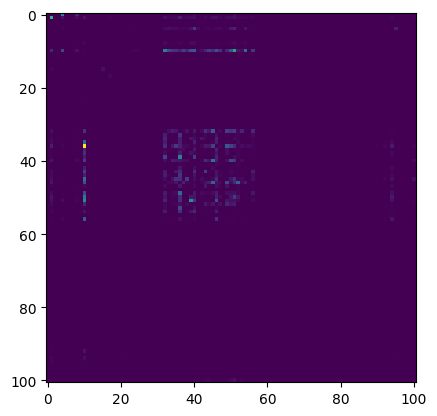

In [243]:
plt.imshow(two_sym_occur)

In [244]:
# Most used bigraphs

k = 3

for i in range(two_sym_occur.shape[0]):
    print()
    print(f"Most used symbols with: {mapper.get_key_from_mapped_code(i)}")
    topk = torch.topk(two_sym_occur[i], k)
    if topk.indices[0].item() == 0.0:
        print("not used")
    else:
        for index, value in zip(topk.indices, topk.values):
            print(f"{mapper.get_key_from_mapped_code(index.item()):10s} (occur: {int(value.item())}) \t", end="")
    print()


Most used symbols with: <SoS>
shift      (occur: 210) 	capslock   (occur: 42) 	t          (occur: 14) 	

Most used symbols with: backspace
backspace  (occur: 293) 	e          (occur: 33) 	space      (occur: 24) 	

Most used symbols with: tab
not used


Most used symbols with: enter
not used


Most used symbols with: shift
i          (occur: 76) 	t          (occur: 42) 	forwardslash (occur: 33) 	

Most used symbols with: ctrl
not used


Most used symbols with: alt
not used


Most used symbols with: pausebreak
not used


Most used symbols with: capslock
i          (occur: 13) 	h          (occur: 12) 	a          (occur: 12) 	

Most used symbols with: esc
not used


Most used symbols with: space
t          (occur: 266) 	a          (occur: 199) 	w          (occur: 158) 	

Most used symbols with: pageup
not used


Most used symbols with: pagedown
not used


Most used symbols with: end
not used


Most used symbols with: home
not used


Most used symbols with: leftarrow
leftarrow  (occur: 19)